In [5]:
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re

df_t = pd.read_csv('QandA.csv')
stop_words = stopwords.words('english')
stop_words.extend(['hello', 'hi', 'welcom', 'headout', 'know', 'experi', 'refer', 'help', 'ani', 'chat', 'problem', 'may', 'reach', 'need', 'let', 'u', 'feel', 'free', 'contact', 'realli', 'appreci', 'could', 'rate', 'chat', 'thank', 'today', 'wa', 'nice', 'talk', 'great', 'day', 'goodby', 'would', 'like','plea', 'wait', 'minut', 'check', 'thi', 'anyth', 'el', 'step', 'away', 'assist', 'custom', 'bye', 'hey', 'ok','get', 'ye', 'safari', 'khalifa', 'burj', 'aquarium', 'roman', 'palatin', 'vatican', 'dubai'])

class preprocess(object):
    '''
    Preprocessing text for classifier
    
    Parameters
    ----------
    text: text to be processed
    stop_words: list of stop_words from nltk
    '''
    def __init__(self, text):
        self.text = text
        
    def tokenizer(self):
        return RegexpTokenizer(r'\w+').tokenize(self.text.lower())
    
    def stem_words(self):
        '''
        Stem words

        Input:
        -----------------------
        List of words

        Return:
        ------------------------
        List of stemmed words
        '''
        porter_stemmer = PorterStemmer()
        return [porter_stemmer.stem(words) for words in self.tokenizer()]
    
    def lemmatize_words(self):
        '''
        Lemmatize words

        Input:
        -----------------------
        List of words

        Return:
        ------------------------
        List of lemmatized words
        '''
        wordnet_lemmatizer = WordNetLemmatizer()
        return [wordnet_lemmatizer.lemmatize(words) for words in self.stem_words()]

    def prep(self, stop_words):
        '''
        Remove stop words

        Input:
        -----------------------
        List of words

        Return:
        ------------------------
        List of words with stop words removed
        '''
        return [word for word in self.lemmatize_words() if word not in stop_words]

In [6]:
preprocess('I will be stepping away get to assist notastopword other customers now, bye! :)').prep(stop_words)

['notastopword']

In [7]:
# Preprocess transcripts
df_l = df_t.QandA.apply(lambda s: ' '.join(preprocess(s).prep(stop_words)))

# Anchored CorEx topic modeling

In [8]:
from corextopic import corextopic as ct
# Build vocabulary list for CorEx topic model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=20000, binary=True)
# Corpus
corpus = cv.fit_transform(df_l)
# Vocabulary
words = list(np.asarray(cv.get_feature_names()))

# Anchor Words for Anchored CorEx
anchor_words = [['cashback', 'cash'], 
                ['refund', 'cancel'], 
                ['child', 'adult','year','old','age','kid'], 
                ['seat', 'choos','select','section','offic','exact','togeth'],
                ['discount','coupon','code','offer'],
                ['card','payment','work','complet','error','issu','differ','tri'],
                ['pm','morn','night']
               ]

# Build model
ntopic = 25
topic_model = ct.Corex(n_hidden=ntopic, max_iter=200, seed=100)
topic_model.fit(corpus, words=words, anchors=anchor_words, anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cashback,cash,wallet,log,facebook,user,creat,futur,virtual,account
1: cancel,refund,polici,strict,reschedul,di,amend,non,money,sono
2: adult,child,year,old,age,kid,abov,yr,18,daughter
3: seat,select,choos,offic,section,exact,togeth,box,map,assign
4: offer,discount,code,coupon,promo,love,wow,appli,unfortun,promot
5: tri,card,differ,work,issu,payment,complet,error,credit,debit
6: pm,night,morn,00,30,10,wish,dure,departur,depart
7: com,http,www,unit,emir,gmail,link,variantid,support,write
8: ticket,buy,purchas,tower,eiffel,onlin,collect,sell,counter,broadway
9: guid,tour,museum,colosseum,access,chapel,sistin,forum,audio,rome
10: meet,versail,point,palac,host,track,pari,specif,outsid,voucher
11: good,pleasur,nope,abt,hv,43,ill,mate,merci,tx
12: cruis,combo,arab,world,pas,dinner,river,singapor,park,zoo
13: id,sagrada,familia,order,sent,send,mail,told,barcelona,proof
14: hotel,pick,peter,st,drop,basilica,la,dune,por,pickup
15: paid,request,intellig,york,best,new,king,lion,school,rock
16: 

## Assign topic with pointwise total correlation

In [9]:
# Documents topic dataframe
df_top = pd.DataFrame(columns = ['logsum','topic','PTC'])
TC = topic_model.log_z
df_top['logsum'] = TC.sum(1)
df_top['topic'] = TC.argmax(1)
# Calculate Pointwise TC for each document
doc_cor = []
for i,row in df_top.iterrows():
    doc_cor.append(TC[i,int(row.topic)])
df_top['PTC'] = doc_cor
df_top.head()

,logsum,topic,PTC
0,58.927235,0,46.491126
1,48.682137,0,27.531751
2,6.146790,5,2.219499
3,22.803795,7,13.259783
4,16.555276,7,5.401563


In [10]:
# Percentage of each topic
df_perc = pd.DataFrame(columns=['topic_no','percentage','keywords'])
df_perc['topic_no'] = list(i for i in range(ntopic))
rowN = float(df_top.shape[0])
for i in range(ntopic):
#     Calculate percentage
    df_perc.at[i,'percentage'] = df_top.loc[(df_top.topic == i) & (df_top.PTC > 8)].shape[0]/rowN
#     Key words
    topic_words,_ = zip(*topics[i])
    df_perc.at[i,'keywords'] = ' ,'.join(topic_words)
    
df_perc.head(7)

,topic_no,percentage,keywords
0,0,0.0143095,"cashback ,cash ,wallet ,log ,facebook ,user ,c..."
1,1,0.0293442,"cancel ,refund ,polici ,strict ,reschedul ,di ..."
2,2,0.0447416,"adult ,child ,year ,old ,age ,kid ,abov ,yr ,1..."
3,3,0.0493805,"seat ,select ,choos ,offic ,section ,exact ,to..."
4,4,0.0526292,"offer ,discount ,code ,coupon ,promo ,love ,wo..."
5,5,0.0459202,"tri ,card ,differ ,work ,issu ,payment ,comple..."
6,6,0.0473557,"pm ,night ,morn ,00 ,30 ,10 ,wish ,dure ,depar..."


# Train Model

In [11]:
# Prepare train set: df_q ===> x; Class label: y
df_q = df_l.loc[(df_top.topic < 7) & (df_top.PTC > 8)]
y = df_top.loc[(df_top.topic < 7) & (df_top.PTC > 8)].topic

# More stop word from product understanding model
slist = pd.read_csv('stop_words_product.csv')[4:120]
stop_words.extend(slist.feature.values.tolist())
df_q = df_q.apply(lambda s: ' '.join(preprocess(s).prep(stop_words)))

# Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(ngram_range=(1,2),max_df=4000, min_df=10)

x = tv.fit_transform(df_q)

# High tfidf terms:
# terms = pd.DataFrame({'term': tv.get_feature_names(), 'tfidf': x.toarray().sum(0)})
# terms.sort_values('tfidf', ascending=False)

In [13]:
# Grid search for hyperparameter alpha
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

nb = MultinomialNB()
nb_param = {'alpha': [1, 0.1, 0.3, 0.005]}
clf = GridSearchCV(nb, nb_param, cv=5, n_jobs=-1, scoring='f1_macro')
clf.fit(x_train, y_train)

clf.cv_results_

{'mean_fit_time': array([0.03225446, 0.03003597, 0.0201406 , 0.01504793]),
 'std_fit_time': array([0.01159376, 0.00396036, 0.00920356, 0.0031189 ]),
 'mean_score_time': array([0.00351334, 0.00423117, 0.00293264, 0.00292525]),
 'std_score_time': array([0.00035996, 0.00186702, 0.00027026, 0.00011677]),
 'param_alpha': masked_array(data=[1, 0.1, 0.3, 0.005],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1}, {'alpha': 0.1}, {'alpha': 0.3}, {'alpha': 0.005}],
 'split0_test_score': array([0.92233824, 0.96049613, 0.94666692, 0.97356147]),
 'split1_test_score': array([0.93922253, 0.96653891, 0.95721368, 0.97451056]),
 'split2_test_score': array([0.93460999, 0.96194698, 0.95510118, 0.9732257 ]),
 'split3_test_score': array([0.9377456 , 0.96512768, 0.95284186, 0.97401101]),
 'split4_test_score': array([0.94027608, 0.96414358, 0.95445818, 0.9729032 ]),
 'mean_test_score': array([0.93483491, 0.96365002, 0.95325542, 0.9736

In [14]:
# test score
from sklearn.metrics import f1_score
nb = MultinomialNB(alpha=0.05)
nb.fit(x_train, y_train)
f1_score(nb.predict(x_test), y_test, average='macro')

0.9660209156709497

# ROC curves

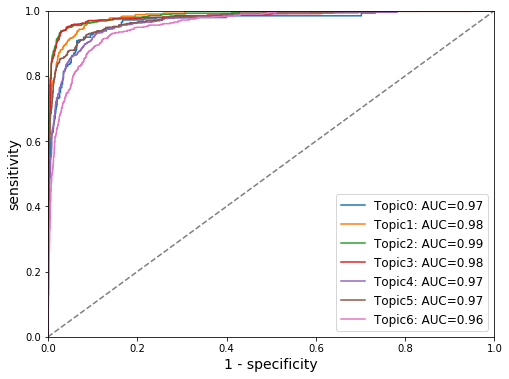

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Cross validation
nb = MultinomialNB(alpha=0.05)
yp = cross_val_predict(nb, x, y, cv=5, method='predict_proba')

# Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(7):
    fpr, tpr, _ = roc_curve(y == i, yp[:,i])
    auc = roc_auc_score(y == i, yp[:,i])
    plt.plot(fpr, tpr, label='Topic%d: AUC=%.2f'%(i,auc))
    plt.legend(loc='lower right',fontsize=12)
plt.plot([0,1],[0,1],'--')
plt.axis([0,1,0,1])
plt.xlabel('1 - specificity',fontsize=14)
plt.ylabel('sensitivity',fontsize=14)
plt.show()

# Save models

In [17]:
nb = MultinomialNB(alpha=0.05)
nb.fit(x,y)

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

In [ ]:
import joblib
# save label encoder
filename = 'Product_Encoder_nb.sav'
joblib.dump(le, filename)

# save tfidf
filename = 'Product_Vectorizer_nb.sav'
joblib.dump(tv, filename)

# save rf model
filename = 'Product_Model_nb.sav'
joblib.dump(nb, filename)